In [35]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [66]:
import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img
from nilearn.image import index_img
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix


import numpy as np
import pandas as pd
import os

## Averiguação da shape do dataset e importação do mesmo

In [67]:
import os

# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
ROOT_DATA='/home/brunomiguel/Documents/data/BIDS_vswp/'
SUB='sub-0001'
SES='ses-001'
TASK='innerspeech'
RUN='run-03'


# data folder
data_path=os.path.join(ROOT_DATA, SUB, SES)
print('The data is in this folder - ' + data_path)

# project folder
ROOT_PROJECT="/Users/home/Documents/GitHub/MVPA-speech_project"




The data is in this folder - /home/brunomiguel/Documents/data/BIDS_vswp/sub-0001/ses-001


In [38]:
fmri_img=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_pp_standard.nii.gz')
dataset_shape=(image.load_img(fmri_img).shape)

print(dataset_shape)
dataset_shape[3]

(91, 109, 91, 258)


258

## Eventos

In [39]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2  # repetition time is ? second
n_scans = dataset_shape[3]  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-' + TASK + '_'+ RUN + '_events.tsv')

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")


## Criação da tabela design_matrix (por fases e não betas)

In [40]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

<AxesSubplot:label='conditions', ylabel='scan number'>

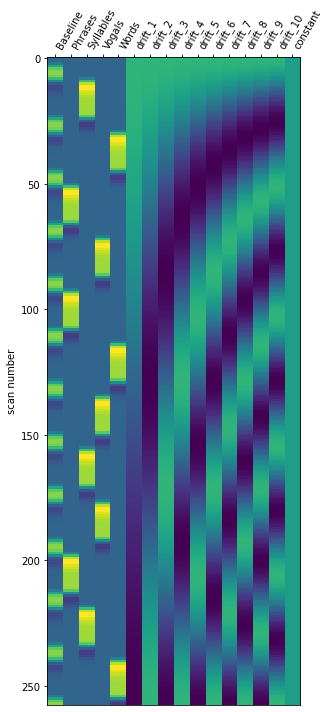

In [41]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(fmri_img, events=events_df)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)

In [42]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
basic_contrasts

{'Baseline': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Phrases': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Syllables': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Vogals': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Words': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_1': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_2': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_3': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_4': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'drift_6': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'drift_7': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.

In [43]:
fmri_glm4mask = FirstLevelModel()
fmri_glm4mask = fmri_glm4mask.fit(fmri_img, design_matrices=design_matrix)

## Beta-series

In [44]:
onset=[]
duration=[]
trialtype=[]

labels=[]

onsett=0
evtt=0

for idx in range(len(events_df)-1):
    block_event=events_df.loc[idx]

    num_evts=block_event['duration']/tr

    for evt in range(int(num_evts)):

        onset.append(onsett)
        onsett+=tr

        duration.append(tr)

        trialtype.append(evtt)
        evtt+=1

        labels.append(block_event['trial_type'])


events_bs = pd.DataFrame({'trial_type': trialtype,
                       'onset': onset,
                       'duration': duration})
events_bs

,trial_type,onset,duration
0,0,0,2
1,1,2,2
2,2,4,2
3,3,6,2
4,4,8,2
...,...,...,...
247,247,494,2
248,248,496,2
249,249,498,2
250,250,500,2


In [45]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data

# save to csv file

labels_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_labels.csv')
savetxt(labels_fn, labels, delimiter=',', fmt="%s")


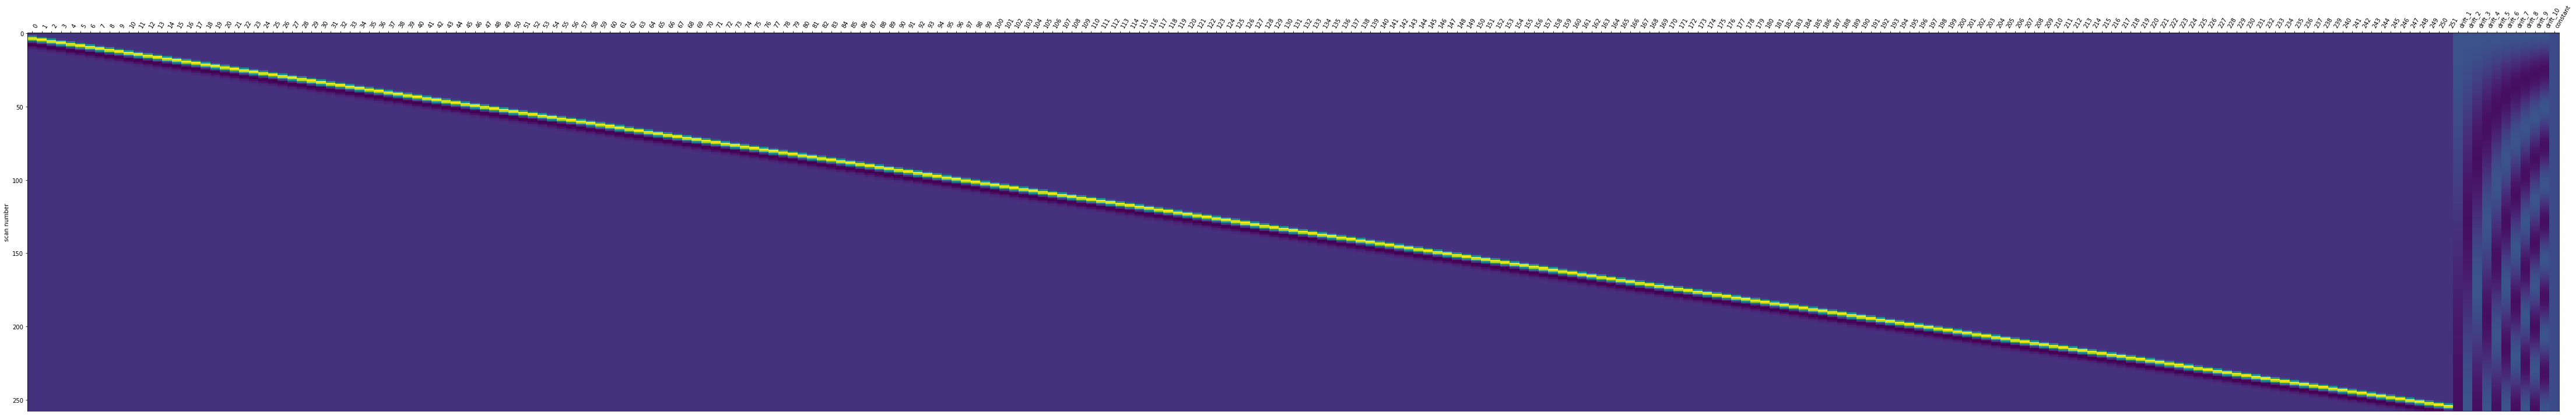

In [46]:
first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(fmri_img, events=events_bs)
design_matrix_b_series = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix_b_series)
design_matrix_b_series.drop({'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'constant'}, axis='columns', inplace=True)

## Contrastes

In [47]:
contrast_matrix_b_series = np.eye(design_matrix_b_series.shape[1])
basic_contrasts_b_series = dict([(column, contrast_matrix_b_series[i]) for i, column in enumerate(design_matrix_b_series.columns)])
    

fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix_b_series)

mean_image = mean_img(fmri_img)
z_map=[]

for idx in range(len(basic_contrasts_b_series)):
    z_map.append(fmri_glm.compute_contrast(basic_contrasts_b_series[idx], output_type='z_score'))
    

In [48]:
contrast_matrix_b_series.shape

(252, 252)

In [49]:
len(basic_contrasts_b_series)

252

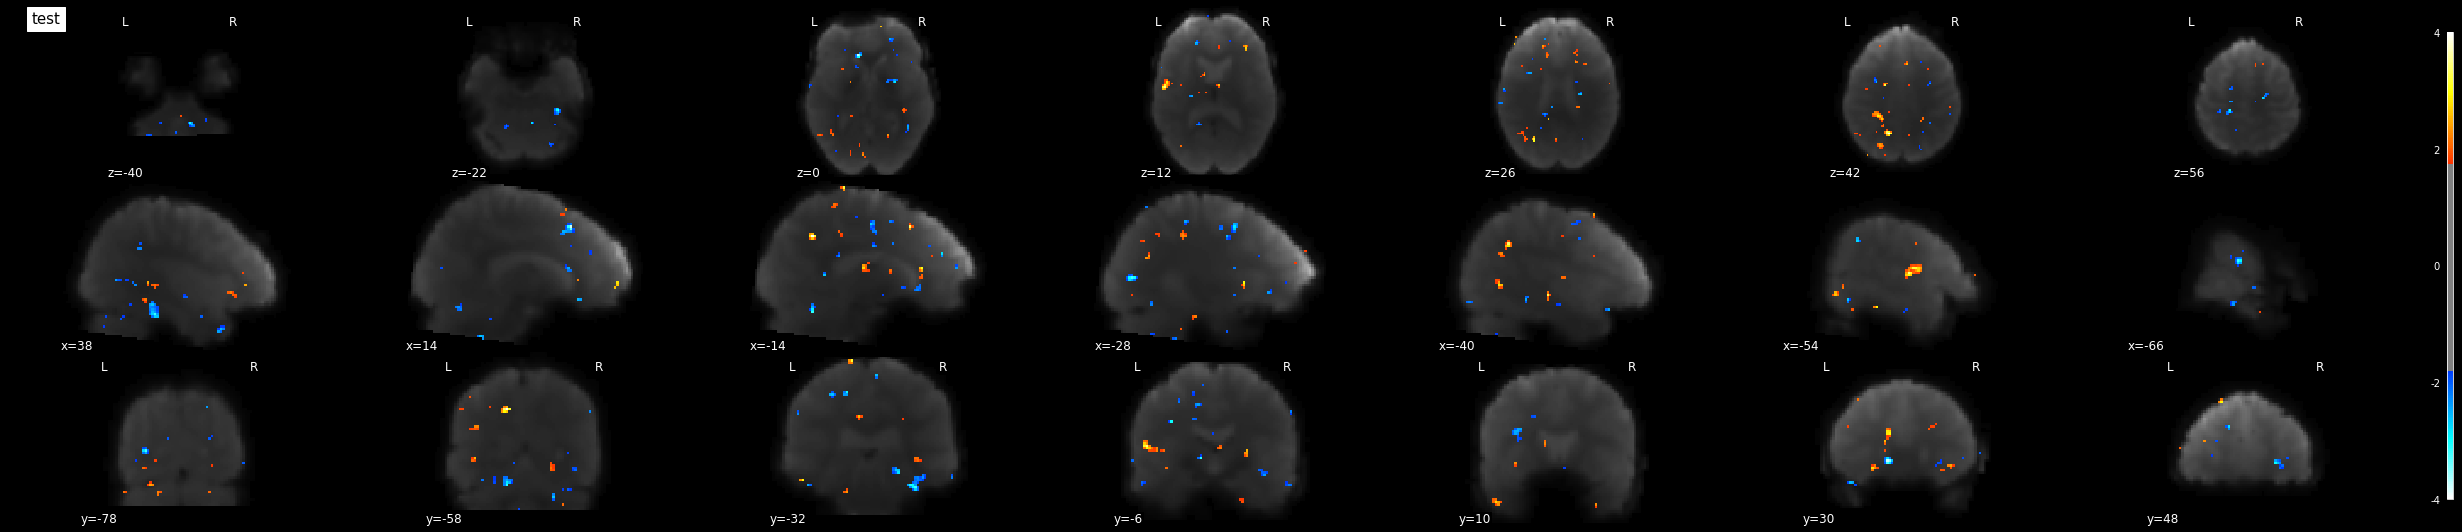

In [50]:
#Teste de imagem
plotting.plot_stat_map(
    z_map[10], bg_img=mean_image, threshold=1.8, display_mode='mosaic', black_bg=True, title='test')
plotting.show()

In [51]:

#bs_fn=os.path.join(data_path, 'func', SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')
import nibabel as nib

bs_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')

img4D=nilearn.image.concat_imgs(z_map)
img4D.to_filename(bs_fn)

In [52]:
del fmri_glm

## As linhas abaixo será para criação de máscaras

In [53]:
#contraste entre frases e baseline
basic_contrasts['+speech-baseline'] = (
    basic_contrasts['Vogals']
    + basic_contrasts['Syllables']
    + basic_contrasts['Words']
    + basic_contrasts['Phrases']
    - basic_contrasts['Baseline'])

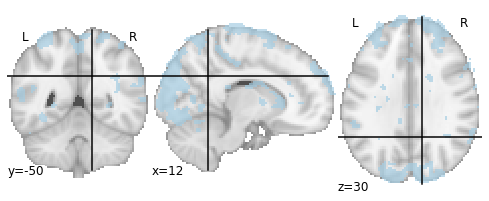

In [54]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker()

brain_mask_map = fmri_glm4mask.compute_contrast(basic_contrasts['+speech-baseline'], output_type='z_score')

brain_mask= nilearn.image.threshold_img(brain_mask_map, threshold=3, copy=False)

masker.fit(brain_mask)

brain_mask=masker.mask_img_

plotting.plot_roi(brain_mask,
                  cmap='Paired')

# save mask
mask_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_mask.nii.gz')

brain_mask.to_filename(mask_fn)


In [60]:
# Load mask

brain_mask= nilearn.image.load_img(mask_fn)


brain_mask_map= nilearn.image.load_img(mask_fn)

plotting.plot_roi(brain_mask, bg_img=mean_image,
                  cmap='Paired')

NameError: name 'mask_fn' is not defined

In [65]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Importação da brain_mask (caso se queira usar gm)

In [ ]:
brain_mask = datasets.load_mni152_brain_mask()

from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()

## Load data

In [68]:
# Load mask
mask_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_mask.nii.gz')
brain_mask= nilearn.image.load_img(mask_fn)

# Load data
bs_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')
bs_maps= nilearn.image.load_img(bs_fn)


# Load labels
labels_fn=os.path.join( SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_labels.csv')
labels=np.genfromtxt(labels_fn,dtype='str')


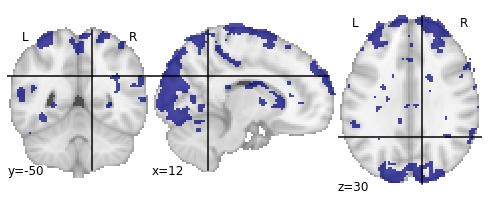

In [69]:
plotting.plot_roi(brain_mask)

In [63]:
dims=bs_maps.shape

img_data = bs_maps.get_fdata()

t_=img_data.reshape(dims[0]*dims[1]*dims[2],dims[3])

In [64]:
print(t_.shape)

(902629, 252)


In [7]:
from sklearn.model_selection import permutation_test_score
from nilearn.decoding import Decoder 


decoder = Decoder(estimator='svc', mask=masker, standardize=True)


null_cv_scores = permutation_test_score(
    decoder, np.transpose(t_), labels, cv=3)
print(null_cv_scores)


NameError: name 'masker' is not defined

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


null_cv_scores = cross_val_score(
    DummyClassifier(strategy='stratified'), np.transpose(t_), labels, cv=3)

print(null_cv_scores)

[0.19047619 0.13095238 0.17857143]


## Cross-validation

In [ ]:
from sklearn.model_selection import KFold
from nilearn.decoding import Decoder 

cv = KFold(n_splits=3)

fold = 0
for train, test in cv.split(labels):
    fold += 1
    decoder = Decoder(estimator='svc', mask=brain_mask, standardize=True)
    decoder.fit(index_img(z_map, train), [labels[i] for i in train])
    prediction = decoder.predict(index_img(z_map, test))
    print(
        "CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(
            fold,
            (prediction == [labels[i] for i in test]).sum() / float(len(
                test))))

In [ ]:
np.unique(labels)

In [9]:
# Decoding
from nilearn.decoding import Decoder 

decoder = Decoder(estimator='svc',cv=3, mask=brain_mask, standardize=True)
decoder.fit(bs_maps, labels)


/home/brunomiguel/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/brunomiguel/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/brunomiguel/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/brunomiguel/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/brunomiguel/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

In [11]:
prediction = decoder.predict(bs_maps)

In [12]:
(prediction == labels).sum()/len(labels)

0.35714285714285715

In [18]:

cv_scores=[]

print(decoder.cv_scores_)
cv_scores=np.mean(decoder.cv_scores_['Phrases'])
    
with open('results.txt', 'a+') as f:
    print(decoder.cv_scores_,file=f)
    print("Phrases | score: %.3f" % (cv_scores),file=f)
        

{'Baseline': [0.5187499999999999, 0.507638888888889, 0.5326388888888889], 'Phrases': [0.5410628019323671, 0.5449275362318842, 0.5420289855072464], 'Syllables': [0.47439613526570046, 0.5140096618357488, 0.485024154589372], 'Vogals': [0.5024154589371981, 0.5120772946859903, 0.5120772946859904], 'Words': [0.5439613526570047, 0.4801932367149758, 0.5236714975845411]}


In [14]:
for i, (param, cv_score) in enumerate(zip(decoder.cv_params_['Words']['C'],
                                          decoder.cv_scores_['Words'])):
    print(param)
    print(cv_score)
        #print("Fold %d | Best SVM parameter: %.1f with score: %.3f" % (i + 1, param, cv_score))

100.0
0.5439613526570047
10.0
0.4801932367149758
100.0
0.5236714975845411


In [ ]:
print(list(decoder.cv_scores_.values()))

classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(classification_accuracy)

In [ ]:
from sklearn.model_selection import permutation_test_score

null_cv_scores = permutation_test_score(
    decoder, bs_maps, labels, cv=3)
print(null_cv_scores)




In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


null_cv_scores = cross_val_score(
    DummyClassifier(), bs_maps, labels,cv=3)
print(null_cv_scores)